## CS310 Natural Language Processing
## Assignment 4. Long Short Term Memory (LSTM) Network for Named Entity Recognition (NER)

**Total points**: 50 + (10 bonus)

In this assignment, you will implement a Long Short Term Memory (LSTM) network for Named Entity Recognition (NER). 

Re-use the code in Lab 5.

## Bonus1: MMEM

### 0. Import Necessary Libraries

In [2]:
TRAIN_PATH = 'data/train.txt'
DEV_PATH = 'data/dev.txt'
TEST_PATH = 'data/test.txt'
EMBEDDINGS_PATH = 'data/glove.6B.100d.txt'
# Download from https://nlp.stanford.edu/data/glove.6B.zip
# It includes dimension 50, 100, 200, and 300.

In [1]:
from pprint import pprint
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from utils import Indexer, read_ner_data_from_connl, get_batch
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import get_tag_indices_from_scores
from metrics import MetricsHandler

In [3]:
train_words, train_tags = read_ner_data_from_connl(TRAIN_PATH)
dev_words, dev_tags = read_ner_data_from_connl(DEV_PATH)
test_words, test_tags = read_ner_data_from_connl(TEST_PATH)
train_words = [word.lower() for word in train_words]
dev_words = [word.lower() for word in dev_words]
test_words = [word.lower() for word in test_words]
print('train words size:', len(train_words))
print('dev words size:', len(dev_words))
print('test words size:', len(test_words))

train words size: 203621
dev words size: 51362
test words size: 46435


In [4]:
print(train_words[:10])
print(train_tags[:10])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', 'peter']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PER']


In [5]:
pprint(list(zip(train_words[:10], train_tags[:10])))

[('eu', 'B-ORG'),
 ('rejects', 'O'),
 ('german', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('british', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O'),
 ('peter', 'B-PER')]


Build Vocab

In [6]:
indexer_train_words = Indexer(train_words)
indexer_train_tags = Indexer(train_tags)
indexer_dev_words = Indexer(dev_words)
indexer_dev_tags = Indexer(dev_tags)
indexer_test_words = Indexer(test_words)
indexer_test_tags = Indexer(test_tags)
# Test
print('index of word "the":', indexer_train_words.element_to_index('the'))
print('index of tag "O":', indexer_train_tags.element_to_index('O'))
print('word with index 0:', indexer_train_words.index_to_element(0))
print('word with index 100:', indexer_train_words.index_to_element(100))
print('tag with index 0:', indexer_train_tags.index_to_element(0))
print('tag with index 1:', indexer_train_tags.index_to_element(1))

index of word "the": 14
index of tag "O": 2
word with index 0: <UNKNOWN>
word with index 100: brains
tag with index 0: <UNKNOWN>
tag with index 1: B-ORG


In [7]:
indexer_words = Indexer(train_words + dev_words + test_words)
indexer_tags = Indexer(train_tags + dev_tags + test_tags)

# Test
print('sizes of indexers from all data:')
print(len(indexer_words), len(indexer_tags))

sizes of indexers from all data:
26870 10


Batching

In [8]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, words, tags, word_indexer, tag_indexer):
        """
        words: List[str]  — 每个元素是一个句子的词序列
        tags:  List[str]  — 每个元素是一个句子的标签序列
        word_indexer: 提供 index_of(word) 的方法
        tag_indexer:  提供 index_of(tag) 的方法
        """
        self.words = words
        self.tags = tags
        self.word_indexer = word_indexer
        self.tag_indexer = tag_indexer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        # print("idx: ",idx)
        word_ids = self.word_indexer.element_to_index(self.words[idx])
        tag_ids = self.tag_indexer.element_to_index(self.tags[idx])
        return torch.tensor(word_ids), torch.tensor(tag_ids)

In [9]:
# TRAIN
train_dataset = NERDataset(train_words, train_tags, indexer_words, indexer_tags)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# DEV
dev_dataset = NERDataset(dev_words, dev_tags, indexer_words, indexer_tags)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=32, shuffle=False)

# TEST
test_dataset = NERDataset(test_words, test_tags, indexer_words, indexer_tags)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
def load_glove_embeddings(glove_path, word_indexer, embedding_dim=100):
    vocab_size = len(word_indexer)
    embeddings = torch.randn(vocab_size, embedding_dim) * 0.1  # 初始化为随机值
    found = 0

    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            splits = line.strip().split()
            word = splits[0]
            vector = list(map(float, splits[1:]))
            if word in word_indexer.get_element_to_index_dict():
                idx = word_indexer.element_to_index(word)
                embeddings[idx] = torch.tensor(vector)
                found += 1

    print(f"Loaded {found} pretrained vectors from GloVe for vocab size {vocab_size}")
    return embeddings


In [11]:
pretrained_embeddings = load_glove_embeddings(EMBEDDINGS_PATH, indexer_words, embedding_dim=100)

embedding_layer = nn.Embedding(num_embeddings=len(indexer_words), embedding_dim=100)
embedding_layer.weight.data.copy_(pretrained_embeddings)


Loaded 22947 pretrained vectors from GloVe for vocab size 26870


tensor([[-2.5884e-01,  6.7199e-02,  1.3480e-01,  ...,  1.4986e-01,
          1.2247e-01, -7.4011e-02],
        [-3.2714e-01,  8.2503e-02,  1.2561e+00,  ...,  3.0425e-01,
          9.3384e-01,  1.0894e-01],
        [ 1.3857e-02,  7.0729e-01,  8.1856e-01,  ...,  1.0097e-01,
          7.5907e-01,  3.6220e-01],
        ...,
        [ 5.6763e-02,  2.7335e-01,  7.0628e-01,  ..., -1.6578e-01,
         -8.5282e-01, -2.5045e-01],
        [-1.3346e-01, -1.0201e-01, -2.0342e-01,  ...,  8.2408e-02,
         -1.2875e+00,  2.8229e-01],
        [-4.6135e-02,  2.4201e-02,  9.4250e-02,  ..., -3.2971e-04,
          2.0109e-01, -8.6816e-02]])

### 1. Build the Model

In [55]:
class MEMMTagger(nn.Module):
    def __init__(
            self,
            vocab_size,
            tagset_size,
            embedding_dim=100,
            hidden_dim=256,
            pretrained_embeddings=None,
            freeze_embeddings=False
    ):
        super(MEMMTagger, self).__init__()

        if pretrained_embeddings is not None:
            self.word_emb = nn.Embedding.from_pretrained(
                embeddings=pretrained_embeddings,
                freeze=freeze_embeddings
            )
            embedding_dim = pretrained_embeddings.size(1)  # 自动获取维度
        else:
            self.word_emb = nn.Embedding(vocab_size, embedding_dim)

        self.tag_emb = nn.Embedding(tagset_size, 50)  # 标签嵌入
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.hidden2tag = nn.Linear(hidden_dim * 2 + 50, tagset_size)

    def forward(self, word_inputs, prev_tag_inputs):
        word_embs = self.word_emb(word_inputs)  # (B, L, D)
        prev_tag_embs = self.tag_emb(prev_tag_inputs)  # (B, L, 50)
        lstm_out, _ = self.lstm(word_embs)  # (B, L, H*2)
        combined = torch.cat([lstm_out, prev_tag_embs], dim=-1)  # (B, L, H*2 + 50)
        tag_scores = torch.log_softmax(self.hidden2tag(combined), dim=-1)  # (B, L, tagset_size)

        return tag_scores

### 2. Train and Evaluate

In [56]:
labels_str = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
labels_int = list(range(len(labels_str)))
# 训练前先创建 MetricsHandler
train_metrics = MetricsHandler(labels_int)
dev_metrics = MetricsHandler(labels_int)
test_metrics = MetricsHandler(labels_int)

def evaluate_model_MEMM(model, data_loader, loss_func, eval_metrics, device):
    model.eval()
    # eval_metrics.collect()  # 初始化评估指标
    running_loss = 0.0

    with torch.no_grad():
        for words, tags in data_loader:
            words, tags = words.to(device), tags.to(device)
            # 使用真实标签作为prev_tag（teacher forcing）
            prev_tags = torch.zeros_like(tags)
            prev_tags[1:] = tags[:-1]
            prev_tags[0] = 2  # 或者 tag2idx["<START>"]

            output = model(words, prev_tags)  # (B, L, tag_size)
            output_flat = output.view(-1, output.size(-1))
            tags_flat = tags.view(-1)
            loss = loss_func(output_flat, tags_flat)
            running_loss += loss.item() * words.size(0)

            # 获取预测与真实标签
            predictions = get_tag_indices_from_scores(output.cpu().numpy())
            tags_list = tags.cpu().numpy().tolist()
            eval_metrics.update(predictions, tags_list)
        eval_metrics.collect()  # 初始化评估指标
    epoch_loss = running_loss / len(data_loader)
    metrics = eval_metrics.get_metrics()
    print(f"[Eval] Loss: {epoch_loss:.4f} | F1-score: {metrics['F1-score'][-1]:.4f}")
    return metrics

def train_model_MEMM(model, data_loader,dev_loader, optimizer, loss_func, train_metrics, num_epochs, device):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # train_metrics.collect()  # 每个 epoch 初始化统计表
        for words, tags in tqdm(data_loader):
            words, tags = words.to(device), tags.to(device)
            prev_tags = torch.zeros_like(tags)
            prev_tags[1:] = tags[:-1]
            prev_tags[0] = 2  # index of tag "O": 2
            # 要用<start>吗？

            optimizer.zero_grad()
            output = model(words, prev_tags)  # output: (B, L, tag_size)
            output_flat = output.view(-1, output.size(-1))  # (B*L, tag_size)
            tags_flat = tags.view(-1)  # (B*L,)
            loss = loss_func(output_flat, tags_flat)
            loss.backward()
            optimizer.step()

            predictions = get_tag_indices_from_scores(output.detach().cpu().numpy())
            # prev_tag = model.tag_embed(predictions)
            tags_list = tags.detach().cpu().numpy().tolist()
            # for pred_seq, true_seq in zip(predictions, tags_list):
            train_metrics.update(predictions, tags_list)
            running_loss += loss.item() * words.size(0)
        train_metrics.collect()
        epoch_loss = running_loss / len(data_loader)
        losses.append(epoch_loss)
        metrics = train_metrics.get_metrics()
        print(f"[Epoch {epoch + 1}] Loss: {epoch_loss:.4f} | F1: {metrics['F1-score'][-1]:.4f}")
        evaluate_model_MEMM(model=MEMMmodel,data_loader=dev_loader,loss_func=loss_fn,eval_metrics=dev_metrics,device=device)
    return model, train_metrics, losses


In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(len(losses) + 1))
    plt.grid(True)
    plt.show()

In [ ]:
def plot_f1_scores(f1_scores, title="F1-score per Epoch"):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='s', color='orange')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.ylim(0, 1.05)
    plt.xticks(range(len(f1_scores) + 1))
    plt.grid(True)
    plt.show()

In [57]:
MEMMmodel = MEMMTagger(
    vocab_size=len(indexer_words),
    tagset_size=len(indexer_tags),
    embedding_dim=100,  # 会被自动覆盖为预训练维度
    hidden_dim=256,
    pretrained_embeddings=pretrained_embeddings,
    freeze_embeddings=False
)


In [58]:
# 超参数
epochs = 10
batch_size = 32
learning_rate = 1e-3

# 损失函数（-1 可设为 pad 标签，若无 pad 可设为默认）
loss_fn = nn.NLLLoss(ignore_index=-1)
optimizer = torch.optim.Adam(MEMMmodel.parameters(), lr=learning_rate)

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEMMmodel = MEMMmodel.to(device)

# === 开始训练 ===
print("Training MEMM...")
model, train_metrics, losses = train_model_MEMM(MEMMmodel, train_loader,dev_loader, optimizer, loss_fn, train_metrics, num_epochs=epochs,device=device)


Training MEMM...


100%|██████████| 6364/6364 [00:36<00:00, 173.44it/s]


[Epoch 1] Loss: 7.7119 | F1: 0.7458
[Eval] Loss: 6.2935 | F1-score: 0.8055


100%|██████████| 6364/6364 [00:37<00:00, 169.66it/s]


[Epoch 2] Loss: 5.0454 | F1: 0.8256
[Eval] Loss: 6.5016 | F1-score: 0.7905


100%|██████████| 6364/6364 [00:37<00:00, 168.54it/s]


[Epoch 3] Loss: 4.3643 | F1: 0.8494
[Eval] Loss: 6.6942 | F1-score: 0.7964


100%|██████████| 6364/6364 [00:32<00:00, 195.02it/s]


[Epoch 4] Loss: 4.0594 | F1: 0.8595
[Eval] Loss: 7.0828 | F1-score: 0.7686


100%|██████████| 6364/6364 [00:36<00:00, 172.79it/s]


[Epoch 5] Loss: 3.9176 | F1: 0.8613
[Eval] Loss: 6.8591 | F1-score: 0.8024


100%|██████████| 6364/6364 [00:42<00:00, 150.45it/s]


[Epoch 6] Loss: 3.8176 | F1: 0.8661
[Eval] Loss: 6.9401 | F1-score: 0.7991


100%|██████████| 6364/6364 [00:40<00:00, 156.73it/s]


[Epoch 7] Loss: 3.7550 | F1: 0.8670
[Eval] Loss: 7.0791 | F1-score: 0.7940


100%|██████████| 6364/6364 [00:42<00:00, 150.15it/s]


[Epoch 8] Loss: 3.7121 | F1: 0.8668
[Eval] Loss: 7.2402 | F1-score: 0.7797


100%|██████████| 6364/6364 [00:36<00:00, 175.62it/s]


[Epoch 9] Loss: 3.6813 | F1: 0.8688
[Eval] Loss: 7.2324 | F1-score: 0.7757


100%|██████████| 6364/6364 [00:36<00:00, 175.00it/s]


[Epoch 10] Loss: 3.6699 | F1: 0.8686
[Eval] Loss: 7.2251 | F1-score: 0.7846


Evaluating MEMM on dev set...
[Eval] Loss: 7.2251 | F1-score: 0.7846
Evaluating MEMM on test set...
[Eval] Loss: 8.9230 | F1-score: 0.7202


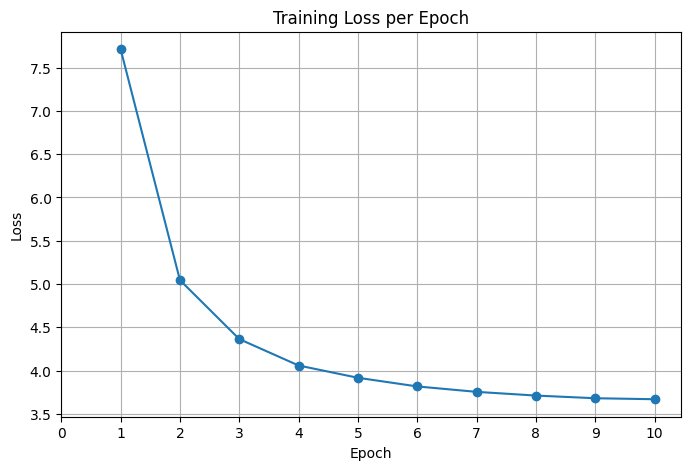

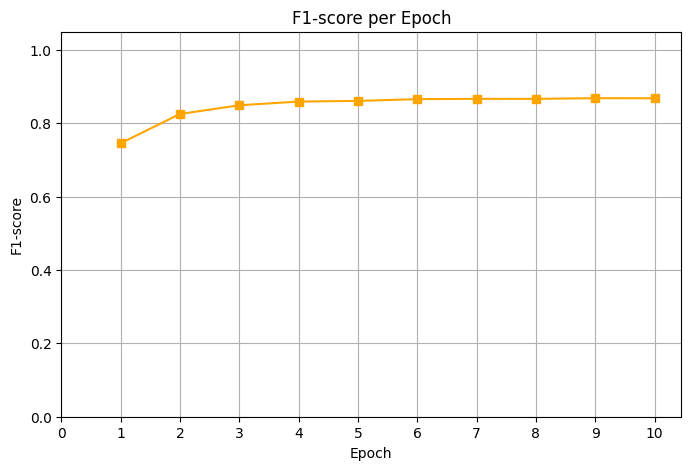

In [59]:
# === 验证集评估 ===
print("Evaluating MEMM on dev set...")
evaluate_model_MEMM(model=MEMMmodel,data_loader=dev_loader,loss_func=loss_fn,eval_metrics=dev_metrics,device=device)

# === 测试集评估 ===
print("Evaluating MEMM on test set...")
evaluate_model_MEMM(model=MEMMmodel,data_loader=test_loader,loss_func=loss_fn,eval_metrics=test_metrics,device=device)

# === 提取训练 F1-score 并可视化 ===
f1_scores = train_metrics.get_metrics()["F1-score"]

plot_losses(losses)
plot_f1_scores(f1_scores)